# Mixture of Experts

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")


## funcs

In [3]:
def add_class(classes=3, boundary=120):
    train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
    test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
    train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
    test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
    if boundary is None:
        # print("1",boundary)
        train_df = add_sbp_class(train_df)
        test_df = add_sbp_class(test_df)
        print(test_df["sbp_class"].nunique())
    else:
        # print("2",boundary,classes)
        train_df = add_sbp_class_2(train_df, boundary=boundary)
        test_df = add_sbp_class_2(test_df, boundary=boundary)
    if classes==2:
        # print("2",boundary,classes)
        train_df = train_df[train_df['sbp_class'] != 1]
        test_df = test_df[test_df['sbp_class'] != 1]
        train_df['sbp_class'] = train_df['sbp_class'] // 2 
        test_df['sbp_class'] = test_df['sbp_class'] // 2
    return train_df, test_df

In [4]:

def add_sbp_class(df, col_name='sbp', new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < 100 → 0
      - 100 <= sbp < 140 → 1
      - sbp >= 140 → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < 100,
        (df[col_name] >= 100) & (df[col_name] < 140),
        df[col_name] >= 140
    ]
    values = [0, 1, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df

def add_sbp_class_2(df, col_name='sbp',boundary=120, new_col='sbp_class'):
    """
    SBP値に応じてクラスを付与する関数
      - sbp < boundary → 0
      - sbp >= boundary → 2

    Parameters
    ----------
    df : pd.DataFrame
        SBP列を含むデータフレーム
    col_name : str, default 'sbp'
        SBPの列名
    new_col : str, default 'sbp_class'
        新しい列名

    Returns
    -------
    df : pd.DataFrame
        新しい列が追加されたDataFrame
    """
    conditions = [
        df[col_name] < boundary,
        df[col_name] >= boundary
    ]
    values = [0, 2]
    df[new_col] = np.select(conditions, values).astype('int')
    return df

In [5]:
from sklearn.model_selection import StratifiedGroupKFold
def get_groupkf(df,k=5, group_col='subject',y_col='sbp_class', random_state=42,get_holdout=False):
    """
    StratifiedGroupKFoldを用いてデータを分割する関数
    Parameters
    ----------
    df : pd.DataFrame
        分割対象のデータフレーム
    k : int, default 5
        分割数
    group_col : str, default 'subject'
        グループ化に使用する列名
    y_col : str, default 'sbp_class'
        ラベル列名 
    random_state : int, default 42
        乱数シード
    get_holdout : bool, default False
        ホールドアウトセットを取得するかどうか
    Returns
    -------
    folds : list of tuples
        各フォールドのデータセットのリスト
        get_holdoutがTrueの場合、各タプルは(train_data, val_data, hold_data)となる
        get_holdoutがFalseの場合、各タプルは(train_data, hold_data)となる
    """
    gkf = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    gkf2 = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=random_state)
    folds = []
    for use_idx, hold_idx in gkf.split(df,df[y_col], groups=df[group_col]):
        u = df.iloc[use_idx]
        h = df.iloc[hold_idx]
        if get_holdout:
            for train_idx, val_idx in gkf2.split(u,u[y_col], groups=u[group_col]):
                t = u.iloc[train_idx]
                v = u.iloc[val_idx]
                break
            print(set(t[group_col]) & set(v[group_col])& set(h[group_col]))
        else:
            print(set(u[group_col]) & set(h[group_col]))
        if get_holdout:
            folds.append((t, v, h))
        else:
            folds.append((u, h))
    return folds
def get_dataset(df,weight=None,return_raw=False,y_col='sbp_class'):
    """
    Daframeから不要な列を除いてLightGBM用のデータセットを作成する関数
    Parameters
    ----------
    df : pd.DataFrame
        特徴量とラベルを含むデータフレーム

    weight : str or None, default None
        クラス重みの指定。Noneの場合は重みなし、'balanced'の場合はバランス調整された重みを使用。
    Returns
    -------
    dataset : lgb.Dataset
        LightGBM用のデータセット
    """ 
    X = df.drop(['signal_index', 'sbp', 'subject', 'dbp','sbp_class','sbp_bin',"bp_class"],axis=1, errors='ignore')
    Y = df[y_col]
    if weight is not None:
        weights = compute_sample_weight(class_weight=weight, y=Y)
        dataset = lgb.Dataset(X, label=Y, weight=weights)
        return dataset
    dataset = lgb.Dataset(X, label=Y)
    if return_raw:
        return [X, Y] 
    return dataset
    

## code

In [6]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
train_df.shape, test_df.shape

((448377, 103), (54892, 103))

3
set()
set()
set()
set()
set()
Iter 1/5 - Val AUC (MoE) = 0.8194 - Baseline val AUC = 0.8497 - Val F1 (MoE) = 0.7523
Iter 2/5 - Val AUC (MoE) = 0.8536 - Baseline val AUC = 0.8497 - Val F1 (MoE) = 0.7749
Iter 3/5 - Val AUC (MoE) = 0.8535 - Baseline val AUC = 0.8497 - Val F1 (MoE) = 0.7741
Iter 4/5 - Val AUC (MoE) = 0.8543 - Baseline val AUC = 0.8497 - Val F1 (MoE) = 0.7746
Iter 5/5 - Val AUC (MoE) = 0.8543 - Baseline val AUC = 0.8497 - Val F1 (MoE) = 0.7750

Final results on test set:
Baseline (single LGBM) - AUC: 0.8690, Acc: 0.7887 , F1: 0.8058
MoE (MLP gate + 3 LGBM experts) - AUC: 0.8729, Acc: 0.7907, F1: 0.8075


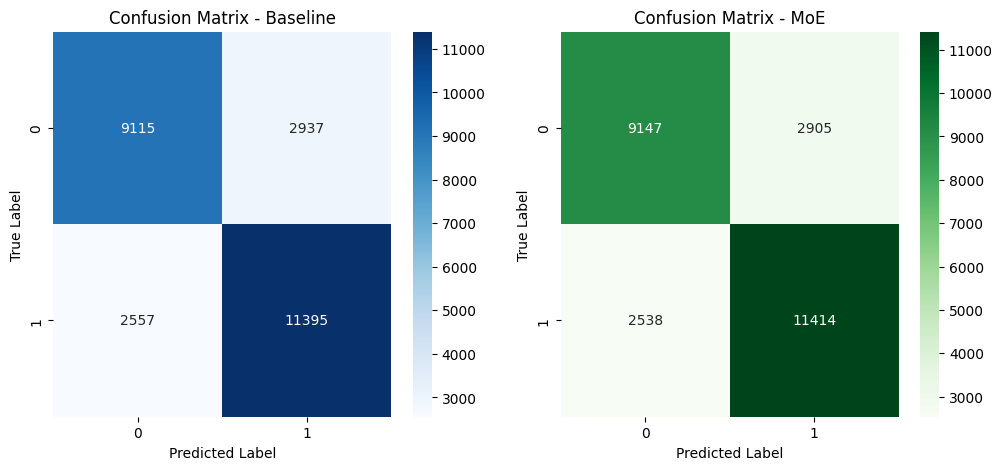

,expert_id,effective_train_weight,expert_val_auc
0,0,56652.063916,0.853680
1,1,56673.930083,0.852992
2,2,56945.006001,0.852731


In [10]:
def run_moe_demo(random_seed=0, verbose=True):
    try:
        np.random.seed(random_seed)
        # Prepare data
        train_df, test_df = add_class(classes=2, boundary=None)
        train_df = train_df.fillna(train_df.mean())
        test_df = test_df.fillna(test_df.mean())
        folds = get_groupkf(train_df, k=5, group_col='subject', y_col='sbp_class', random_state=42)
        train,val = folds[0]
        X_train,y_train = get_dataset(train, return_raw=True)
        X_val,y_val = get_dataset(val, return_raw=True)
        X_test,y_test = get_dataset(test_df, return_raw=True)
        baseline = lgb.LGBMClassifier(n_estimators=80, random_state=random_seed, verbose=-1)
        baseline.fit(X_train, y_train)
        base_val_prob = baseline.predict_proba(X_val)[:,1]
        base_test_prob = baseline.predict_proba(X_test)[:,1]
        baseline_val_auc = roc_auc_score(y_val, base_val_prob)
        baseline_test_auc = roc_auc_score(y_test, base_test_prob)

        K = 3
        max_iters = 5

        kmeans = KMeans(n_clusters=K, random_state=random_seed).fit(X_train)
        hard_labels = kmeans.labels_
        R = np.zeros((X_train.shape[0], K))
        R[np.arange(X_train.shape[0]), hard_labels] = 1.0

        experts = [None] * K

        def bce_per_sample(y_true, p_pred, eps=1e-12):
            p = np.clip(p_pred, eps, 1-eps)
            return -(y_true * np.log(p) + (1-y_true) * np.log(1-p))

        gate = None
        for it in range(max_iters):
            # Train experts
            for k in range(K):
                sample_weight = R[:,k].copy()
                if sample_weight.sum() <= 0:
                    sample_weight = np.ones_like(sample_weight) * 1e-6
                else:
                    sample_weight = sample_weight * (len(sample_weight)/ (sample_weight.sum() + 1e-12))
                clf = lgb.LGBMClassifier(n_estimators=120, random_state=random_seed, verbose=-1)
                clf.fit(X_train, y_train, sample_weight=sample_weight)
                experts[k] = clf

            # expert probs on train
            expert_probs = np.column_stack([experts[k].predict_proba(X_train)[:,1] for k in range(K)])
            losses = np.column_stack([bce_per_sample(y_train, expert_probs[:,k]) for k in range(K)])
            exp_neg = np.exp(-losses)
            R_new = exp_neg / (exp_neg.sum(axis=1, keepdims=True) + 1e-12)

            # train gate as regressor
            gate = MLPRegressor(hidden_layer_sizes=(64,32), max_iter=300, random_state=random_seed)
            gate.fit(X_train, R_new)

            gate_out = gate.predict(X_train)
            e = np.exp(gate_out - gate_out.max(axis=1, keepdims=True))
            R = e / (e.sum(axis=1, keepdims=True) + 1e-12)

            # val eval
            expert_val_probs = np.column_stack([experts[k].predict_proba(X_val)[:,1] for k in range(K)])
            gate_val_out = gate.predict(X_val)
            e_val = np.exp(gate_val_out - gate_val_out.max(axis=1, keepdims=True))
            gate_val_probs = e_val / (e_val.sum(axis=1, keepdims=True) + 1e-12)
            mix_val_prob = (gate_val_probs * expert_val_probs).sum(axis=1)
            val_auc = roc_auc_score(y_val, mix_val_prob)
            val_f1 = f1_score(y_val, (mix_val_prob>0.5).astype(int))
            if verbose:
                print(f"Iter {it+1}/{max_iters} - Val AUC (MoE) = {val_auc:.4f} - Baseline val AUC = {baseline_val_auc:.4f} - Val F1 (MoE) = {val_f1:.4f}")

        # final test eval
        expert_test_probs = np.column_stack([experts[k].predict_proba(X_test)[:,1] for k in range(K)])
        gate_test_out = gate.predict(X_test)
        e_test = np.exp(gate_test_out - gate_test_out.max(axis=1, keepdims=True))
        gate_test_probs = e_test / (e_test.sum(axis=1, keepdims=True) + 1e-12)
        mix_test_prob = (gate_test_probs * expert_test_probs).sum(axis=1)
        moe_test_auc = roc_auc_score(y_test, mix_test_prob)
        moe_test_acc = accuracy_score(y_test, (mix_test_prob>0.5).astype(int))
        f1_test = f1_score(y_test, (mix_test_prob>0.5).astype(int))
        baseline_test_acc = accuracy_score(y_test, (base_test_prob>0.5).astype(int))
        baseline_test_f1 = f1_score(y_test, (base_test_prob>0.5).astype(int))

        if verbose:
            print("\nFinal results on test set:")
            print(f"Baseline (single LGBM) - AUC: {baseline_test_auc:.4f}, Acc: {baseline_test_acc:.4f}", f", F1: {baseline_test_f1:.4f}")
            print(f"MoE (MLP gate + {K} LGBM experts) - AUC: {moe_test_auc:.4f}, Acc: {moe_test_acc:.4f}, F1: {f1_test:.4f}")

        df = pd.DataFrame({
            "expert_id": np.arange(K),
            "effective_train_weight": R.sum(axis=0),
            "expert_val_auc": [roc_auc_score(y_val, experts[k].predict_proba(X_val)[:,1]) for k in range(K)]
        })
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns
        cm_baseline = confusion_matrix(y_test, (base_test_prob>0.5).astype(int))
        cm_moe = confusion_matrix(y_test, (mix_test_prob>0.5).astype(int))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - Baseline')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')


        plt.subplot(1, 2, 2)
        sns.heatmap(cm_moe, annot=True, fmt='d', cmap='Greens')
        plt.title('Confusion Matrix - MoE')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        return {
            "baseline_val_auc": baseline_val_auc,
            "baseline_test_auc": baseline_test_auc,
            "moe_test_auc": moe_test_auc,
            "moe_test_acc": moe_test_acc,
            "baseline_test_acc": baseline_test_acc,
            "experts_summary": df
        }

    except Exception as e:
        print("Error during run:", e)
        raise

res = run_moe_demo(random_seed=0, verbose=True)
res["experts_summary"]

In [9]:
from sklearn.metrics import confusion_matrix
cm_baseline = confusion_matrix(y_test, (base_test_prob>0.5).astype(int))
cm_moe = confusion_matrix(y_test, (mix_test_prob>0.5).astype(int))

NameError: name 'y_test' is not defined